<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 1:


* In this notebook, we will build a `DNN` model for classifying MNIST digits. The `DNN` model will consist of 784 input nodes, a hidden layer with 128 nodes and 10 output nodes (corresponding to the 10 digits).
* We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation.
* After training and evaluating our `DNN` model we analyze its performance. In particular, we use confusion matrices to compare the `predicted classes` with the `class labels` to try to determine why some images were misclassified by the model.
* We then obtain the 60,000 `activation values` of one of the hidden nodes for the (original) set of training data. We want to use these `activation values` as "proxies" for the predicted classes of the 60,000 images.
* And just like we compared the `predicted classes` with the `class labels` using confusion matrices to determine the efficacy of the model, we use `box plots` to visualize the relationship between the `activation values` of one hidden node and the `class labels`. We don't expect these activation values to have much "predictive power". In fact, the same activation values can be associated with multiple class labels resulting in a lot of overlap in the `box plots`.
* We also perform similar experiments comparing the values at two pixel locations in the images with the class labels. This time we use `scatter plots` to visualize the relationship between the pair of pixel values with the class labels (represented by different colored dots).
* Pixel values at two locations in image should not have much predictive value. To improve on this approach, we the PCA decomposition on both the raw data of 784 pixel values and 128 hidden node activation values to reduce the number of features to 2 in each case. Once again, we use a `scatter plot` to visualize the correlation between the two principal component values and the class labels.
*  Finally, we use a Random Forest Classifier to find the relative importance of the 784 features (pixels) in the training set. We then select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

## Importing Packages

* First we import all the packages that will be used in the assignment.

* Since Keras is integrated in TensorFlow 2.x, we import `keras` from `tensorflow` and use `tenserflow.keras.xxx` to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.18.0


In [4]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


## Mount Google Drive to Colab environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Research Assignment Reporting Functions

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

    return mtx

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

## Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [7]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [8]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


## Review labels for training set

In [9]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



## Find frequency of each label in training and test sets

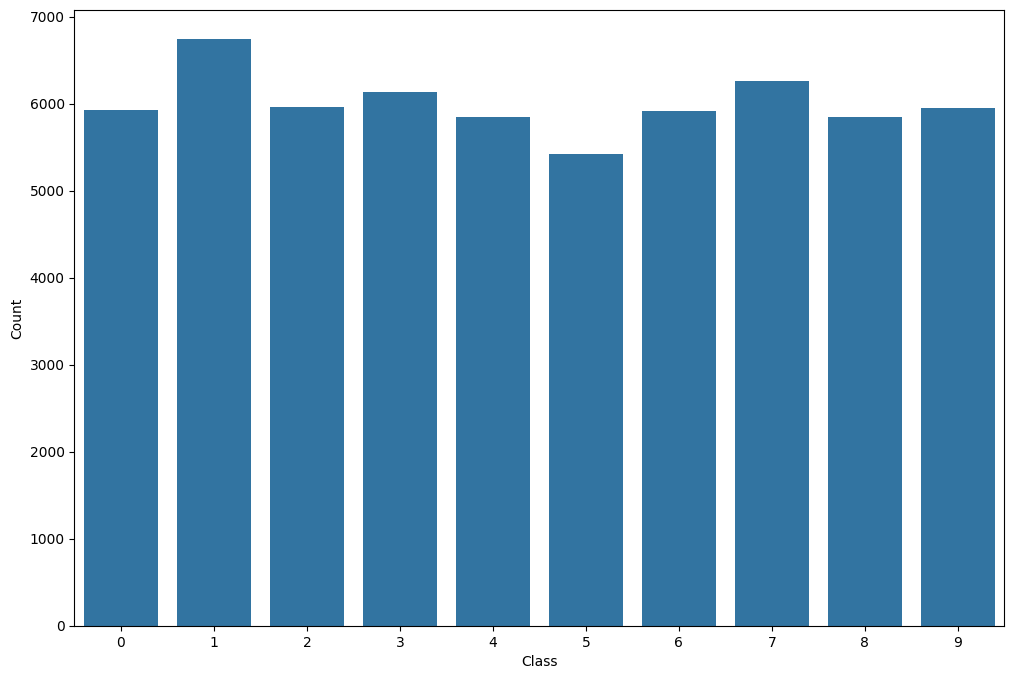

In [10]:
plt.figure(figsize = (12 ,8))
items = [{'Class': x, 'Count': y} for x, y in Counter(y_train).items()]
distribution = pd.DataFrame(items).sort_values(['Class'])
sns.barplot(x=distribution.Class, y=distribution.Count);

In [11]:
Counter(y_train).most_common()

[(np.uint8(1), 6742),
 (np.uint8(7), 6265),
 (np.uint8(3), 6131),
 (np.uint8(2), 5958),
 (np.uint8(9), 5949),
 (np.uint8(0), 5923),
 (np.uint8(6), 5918),
 (np.uint8(8), 5851),
 (np.uint8(4), 5842),
 (np.uint8(5), 5421)]

In [12]:
Counter(y_test).most_common()

[(np.uint8(1), 1135),
 (np.uint8(2), 1032),
 (np.uint8(7), 1028),
 (np.uint8(3), 1010),
 (np.uint8(9), 1009),
 (np.uint8(4), 982),
 (np.uint8(0), 980),
 (np.uint8(8), 974),
 (np.uint8(6), 958),
 (np.uint8(5), 892)]

## Plot sample images with their labels

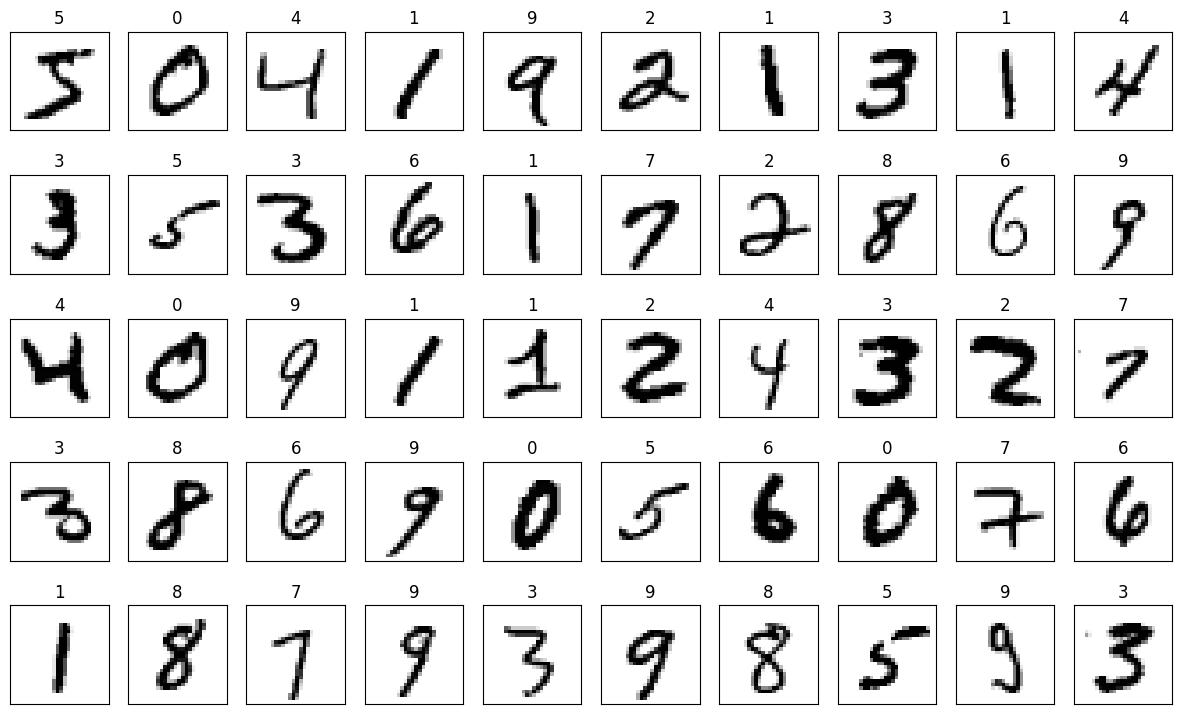

In [13]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

##  Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [14]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [15]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


## Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [16]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [17]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [18]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

## Review unique values with set from 1st image

In [19]:
print(set(x_train_reshaped[0]))

{np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(9), np.uint8(11), np.uint8(14), np.uint8(16), np.uint8(18), np.uint8(23), np.uint8(24), np.uint8(25), np.uint8(26), np.uint8(27), np.uint8(30), np.uint8(35), np.uint8(36), np.uint8(39), np.uint8(43), np.uint8(45), np.uint8(46), np.uint8(49), np.uint8(55), np.uint8(56), np.uint8(64), np.uint8(66), np.uint8(70), np.uint8(78), np.uint8(80), np.uint8(81), np.uint8(82), np.uint8(90), np.uint8(93), np.uint8(94), np.uint8(107), np.uint8(108), np.uint8(114), np.uint8(119), np.uint8(126), np.uint8(127), np.uint8(130), np.uint8(132), np.uint8(133), np.uint8(135), np.uint8(136), np.uint8(139), np.uint8(148), np.uint8(150), np.uint8(154), np.uint8(156), np.uint8(160), np.uint8(166), np.uint8(170), np.uint8(171), np.uint8(172), np.uint8(175), np.uint8(182), np.uint8(183), np.uint8(186), np.uint8(187), np.uint8(190), np.uint8(195), np.uint8(198), np.uint8(201), np.uint8(205), np.uint8(207), np.uint8(212), np.uint8(213), np.uint8(219), np.

## Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [20]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [21]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{np.float32(0.0), np.float32(0.011764706), np.float32(0.53333336), np.float32(0.07058824), np.float32(0.49411765), np.float32(0.6862745), np.float32(0.101960786), np.float32(0.6509804), np.float32(1.0), np.float32(0.96862745), np.float32(0.49803922), np.float32(0.11764706), np.float32(0.14117648), np.float32(0.36862746), np.float32(0.6039216), np.float32(0.6666667), np.float32(0.043137256), np.float32(0.05490196), np.float32(0.03529412), np.float32(0.85882354), np.float32(0.7764706), np.float32(0.7137255), np.float32(0.94509804), np.float32(0.3137255), np.float32(0.6117647), np.float32(0.41960785), np.float32(0.25882354), np.float32(0.32156864), np.float32(0.21960784), np.float32(0.8039216), np.float32(0.8666667), np.float32(0.8980392), np.float32(0.7882353), np.float32(0.52156866), np.float32(0.18039216), np.float32(0.30588236), np.float32(0.44705883), np.float32(0.3529412), np.float32(0.15294118), np.float32(0.6745098), np.float32(0.88235295), np.float32(0.99215686), np.float32(0.949

## Creating the DNN Model

* In this step, we first choose the network architecture for the model. Then we build.compile, train and evaulate the model.

## Specify the network architecture

Below is the neural network architecture we will use today for classifying MNIST digits.
<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/DNN_architecture.png?raw=1" />

## Build the DNN model

We use a `Sequential` class defined in `Keras` to create our model. All the layers are going to be Dense layers. This means, like the figure shown above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

After the model is built, we view ....

In [22]:
k.clear_session()
model = Sequential([
    Dense(input_shape=[784], units=128, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

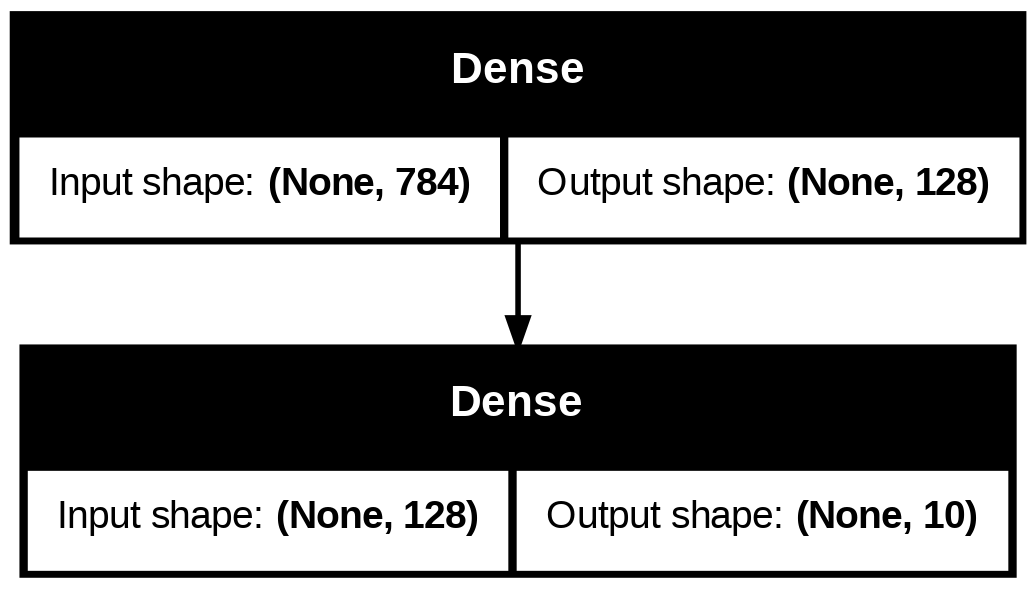

In [24]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True)

## Compile the DNN model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimized in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimizes the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.


<b>tf.keras.optimizers.RMSprop</b><br>
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop


<b>tf.keras.losses.CategoricalCrossentropy</b><br>
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


In [25]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

## Train the DNN model

<b>tf.keras.model.fit</b><br>
  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [26]:
history = model.fit(
    x_train_norm
    ,y_train_encoded
    ,epochs = 200
    ,validation_split=0.20
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.keras",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )

Epoch 1/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8701 - loss: 0.5990 - val_accuracy: 0.9506 - val_loss: 0.2515
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9516 - loss: 0.2474 - val_accuracy: 0.9613 - val_loss: 0.2064
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9604 - loss: 0.2035 - val_accuracy: 0.9630 - val_loss: 0.1910
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9650 - loss: 0.1790 - val_accuracy: 0.9662 - val_loss: 0.1713
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9677 - loss: 0.1689 - val_accuracy: 0.9680 - val_loss: 0.1671
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9697 - loss: 0.1578 - val_accuracy: 0.9677 - val_loss: 0.1651
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9704 - loss: 0.1546 - val_accuracy: 0.9628 - val_loss: 0.1798


## Evaluate the DNN model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [27]:
model = tf.keras.models.load_model("DNN_model.keras", custom_objects={'softmax_v2': tf.keras.activations.softmax})
print(f"Test acc: {model.evaluate(x_test_norm, y_test_encoded)[1]:.3f}")
# The code above explicitly tells the load_model function to map 'softmax_v2' to the standard softmax activation function.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9622 - loss: 0.1752
Test acc: 0.968


In [28]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

## Making Predictions

In [29]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
shape of preds:  (10000, 10)


In [30]:
def PlotTestImages(start_index=0):

  plt.figure(figsize = (12, 8))

  for i in range(25):
      plt.subplot(5, 5, i + 1)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      pred = np.argmax(preds[start_index + i])
      actual = np.argmax(y_test_encoded[start_index + i])
      col = 'g'
      if pred != actual:
          col = 'r'
      plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
      plt.imshow(x_test[start_index + i], cmap='binary')
  plt.show()


Look at the first 25 - Plot test set images along with their predicted and actual labels to understand how the trained model actually performed. start_index can be changed to look at other plots

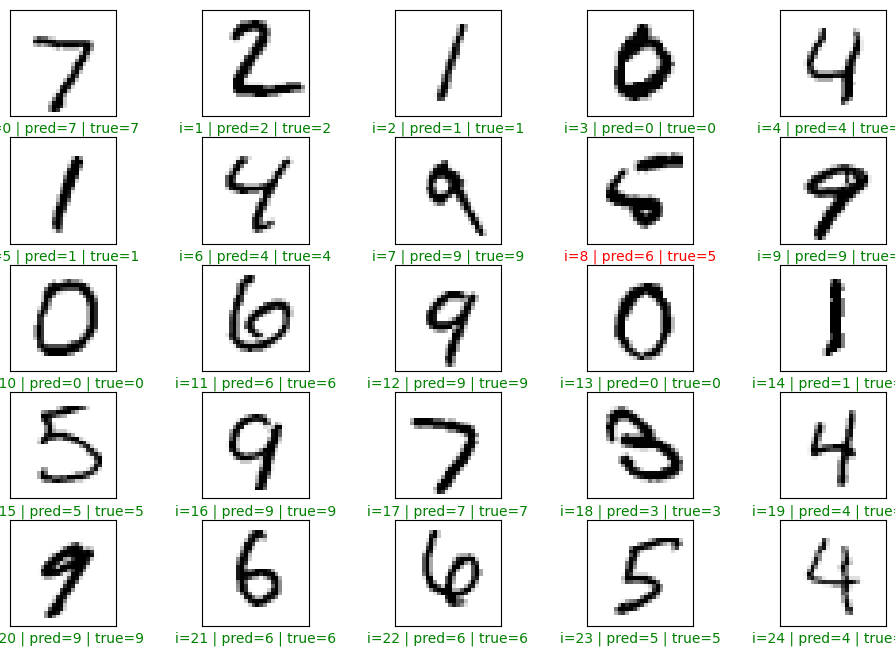

In [31]:
PlotTestImages(start_index=0)

##  Reviewing Performance

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

## Plot performance metrics

We use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [35]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,accuracy,loss,val_accuracy,val_loss
2,0.961,0.198,0.963,0.191
3,0.964,0.180,0.966,0.171
4,0.967,0.171,0.968,0.167
5,0.968,0.162,0.968,0.165
6,0.970,0.157,0.963,0.180


In [36]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

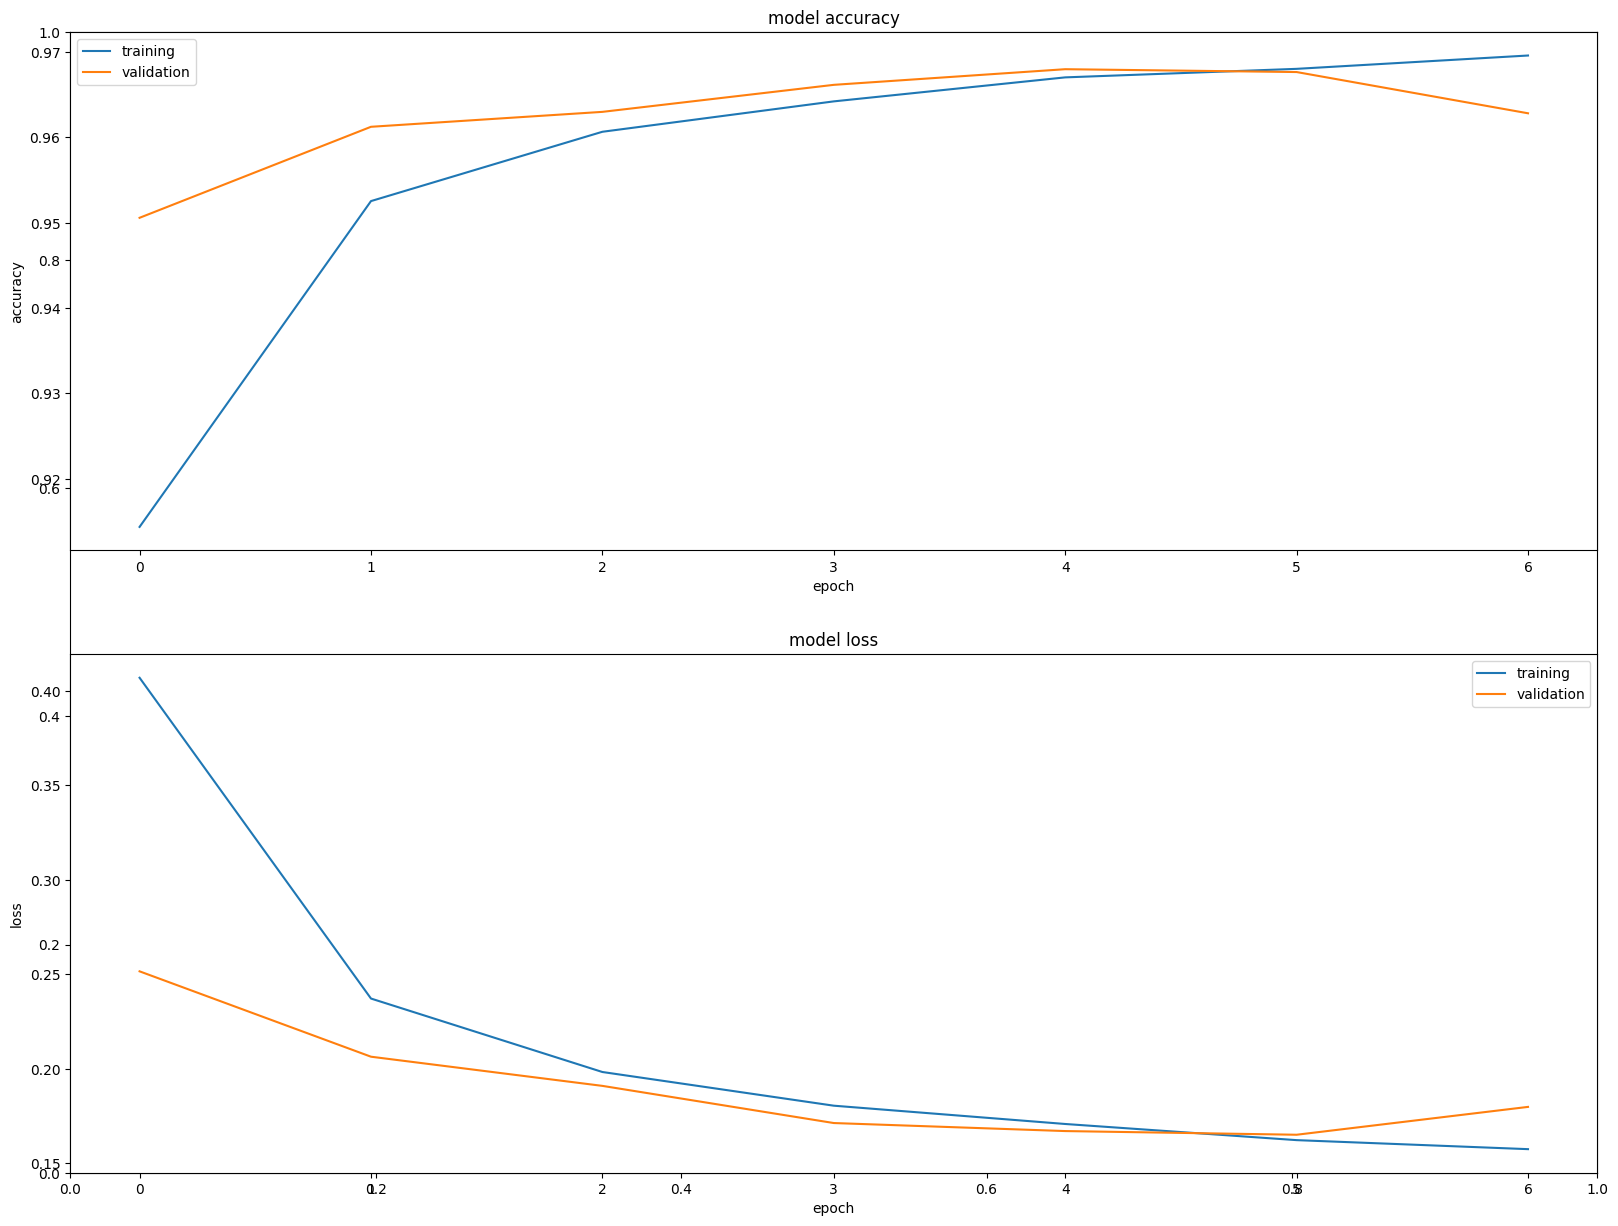

In [37]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)

In [38]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [39]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.99      0.95      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.97      0.94      0.95       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy Score: 0.9684
Root Mean Square Error: 0.7951729371652433


## Create the confusion matrix

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [40]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [41]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [42]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,99.99%,0.00%,0.01%
1,0.01%,0.00%,99.73%,0.15%,0.00%,0.01%,0.03%,0.00%,0.07%,0.00%
2,0.00%,98.95%,0.08%,0.04%,0.05%,0.01%,0.05%,0.67%,0.14%,0.01%
3,99.99%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,0.00%,0.00%,0.05%,0.00%,99.17%,0.00%,0.02%,0.11%,0.03%,0.62%
5,0.00%,99.03%,0.00%,0.01%,0.02%,0.00%,0.00%,0.92%,0.02%,0.01%
6,0.00%,0.00%,0.00%,0.00%,95.60%,0.01%,0.00%,0.11%,2.79%,1.47%
7,0.00%,0.00%,0.00%,0.20%,0.04%,0.01%,0.00%,0.11%,0.01%,99.63%
8,0.09%,0.00%,2.65%,0.00%,0.00%,4.75%,92.36%,0.00%,0.10%,0.04%
9,0.00%,0.00%,0.00%,0.00%,0.04%,0.00%,0.00%,0.05%,0.10%,99.81%


## Visualize the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates.

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

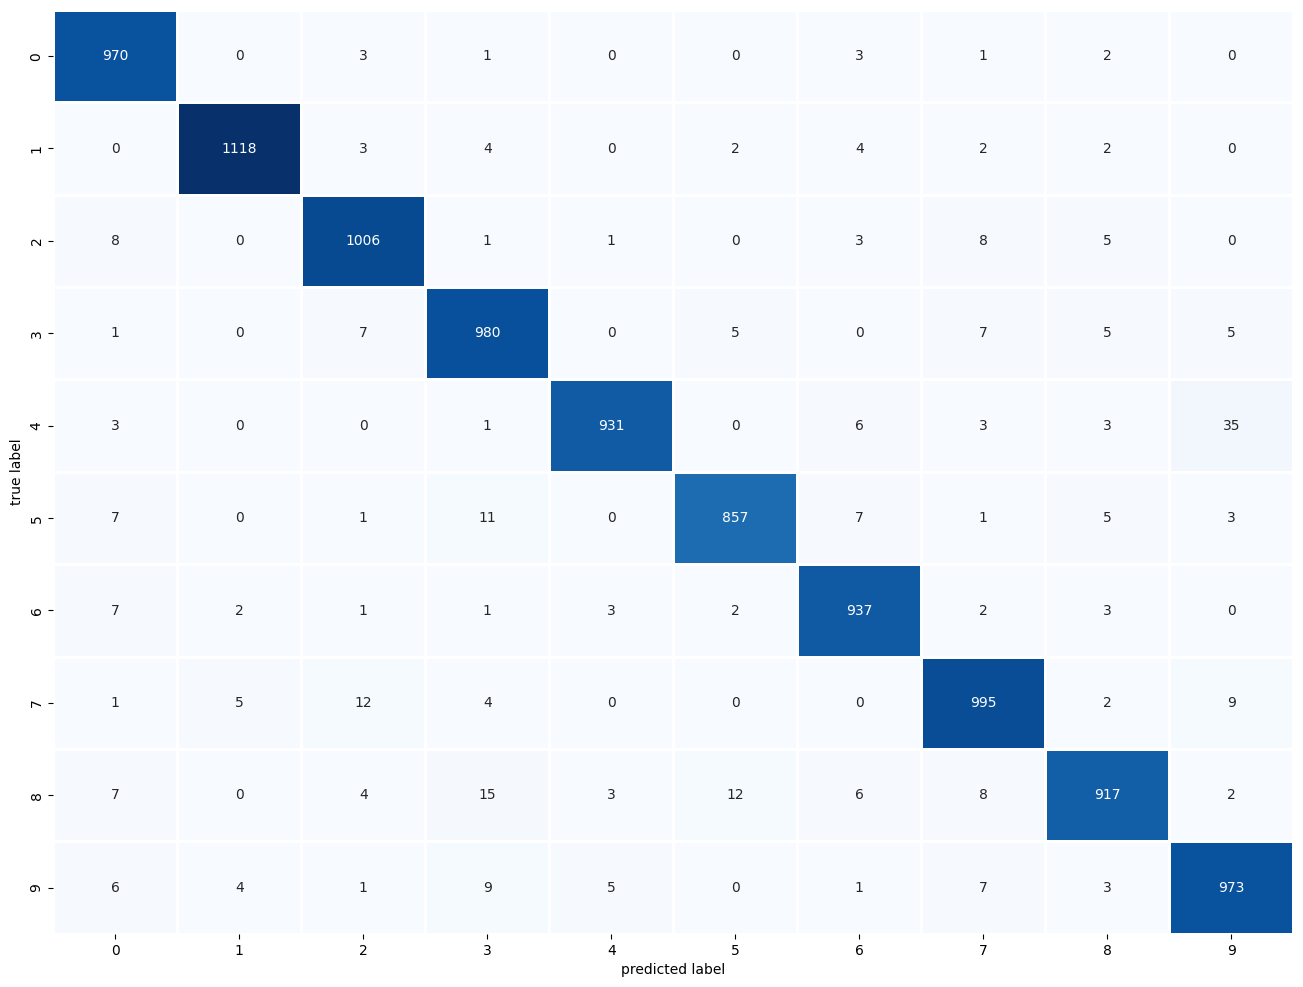

In [43]:
mtx = plot_confusion_matrix(y_test,pred_classes)

In [44]:
print(f'Looks like {mtx[4,9]} fours were misclassified as nines (and {mtx[9,4]} nines were classifed fours). We display some of these misclassfications along with exam of fours and nines that were correctly identified.')

Looks like 35 fours were misclassified as nines (and 5 nines were classifed fours). We display some of these misclassfications along with exam of fours and nines that were correctly identified.


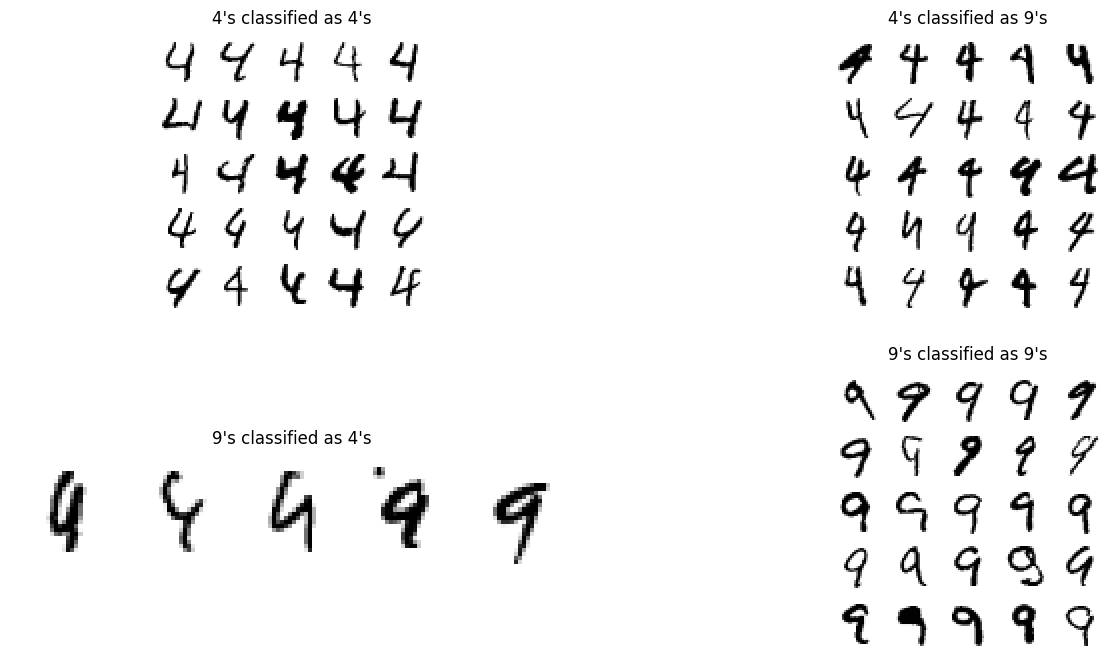

In [45]:
cl_a, cl_b = 4, 9
X_aa = x_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = x_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = x_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = x_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

## Analyzing the Activation Values of the Hidden Nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these *128 activations* as the features that determine the classification class. For the sake of comparison,  we also consider the *784 pixels* of each training image and determine the contribution of the individual pixels to the predicted classification class.

Our goal is to use *box* and *scatter* plots to visualize how these features (*pixel* and *activation* values) correlate with the class labels. Because of the high dimension of the feature spaces, we apply *PCA decomposition* and *t-Distributed stochastic neighbor embedding* (`t-SNE`) to reduce the number of features in each case.

We use the following two articles as reference

 * https://medium.com/data-science-365/principal-component-analysis-pca-with-scikit-learn-1e84a0c731b0
 * https://towardsdatascience.com/dimensionality-reduction-with-pca-and-t-sne-in-python-c80c680221d



1) Raw data is 60,000 X 784. Just do a scatter plot of col 1 vs col 2. Overlay the color coded classes. We  should not see any patterns since there is not much info in 2 cols to discriminate.

2) PCA of raw data – as we discussed earlier. Plot PC1 vs PC2 with overlay. This should be ‘better’ since these 2 capture the info from all 784 cols.

3) PCA of activation values – as we discussed earlier. This should be ‘better’ than the previous 2 since it has captured specific features of discrimination.

 ## Get Activation Values of the Hidden Nodes (128)

To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [46]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.inputs, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [47]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


(60000, 128)

In [48]:
output_layer_activations.shape

(60000, 10)

In [49]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 5.58768892288208


In [50]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.    0.    0.    0.027 0.    0.973 0.    0.    0.    0.   ]
The sum of the probabilities is (approximately) 1.0


 ## Create a dataframe with the activation values and the class labels

In [51]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,128):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.000,1.000,9.000,2.000,1.000,3.000,1.000,4.000,3.000,5.000,3.000,6.000,1.000
act_val_0,0.179,0.976,0.000,1.205,0.000,0.000,0.000,0.699,0.000,0.000,0.428,0.850,0.363,0.000,0.000
act_val_1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
act_val_2,0.000,1.188,0.000,0.000,0.000,0.000,0.903,0.000,1.248,0.328,0.363,0.000,0.131,1.243,1.155
act_val_3,0.000,0.411,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_123,0.000,0.304,0.435,0.308,0.152,0.665,0.257,0.191,0.180,0.468,0.000,0.528,0.000,0.675,0.291
act_val_124,1.002,0.295,0.000,0.867,0.163,0.108,0.714,1.290,0.756,1.334,1.578,1.034,0.000,0.355,0.873
act_val_125,0.659,1.103,0.006,0.000,0.000,1.830,0.000,0.902,0.000,1.011,0.389,0.692,0.000,0.601,0.000
act_val_126,1.024,0.000,0.000,0.023,0.000,0.116,1.198,0.749,0.599,0.000,1.172,0.000,2.091,0.000,0.516


 ## Visualize the activation values with boxplots

We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe.

<div class="alert alert-block alert-info">
    <b>seaborn.boxplot</b><br>
   ps://seaborn.pydata.org/generated/seaborn.boxplot.html
    </div>

<ipython-input-52-9104d3ce550e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.boxplot(y=act_val, x='actual_class',


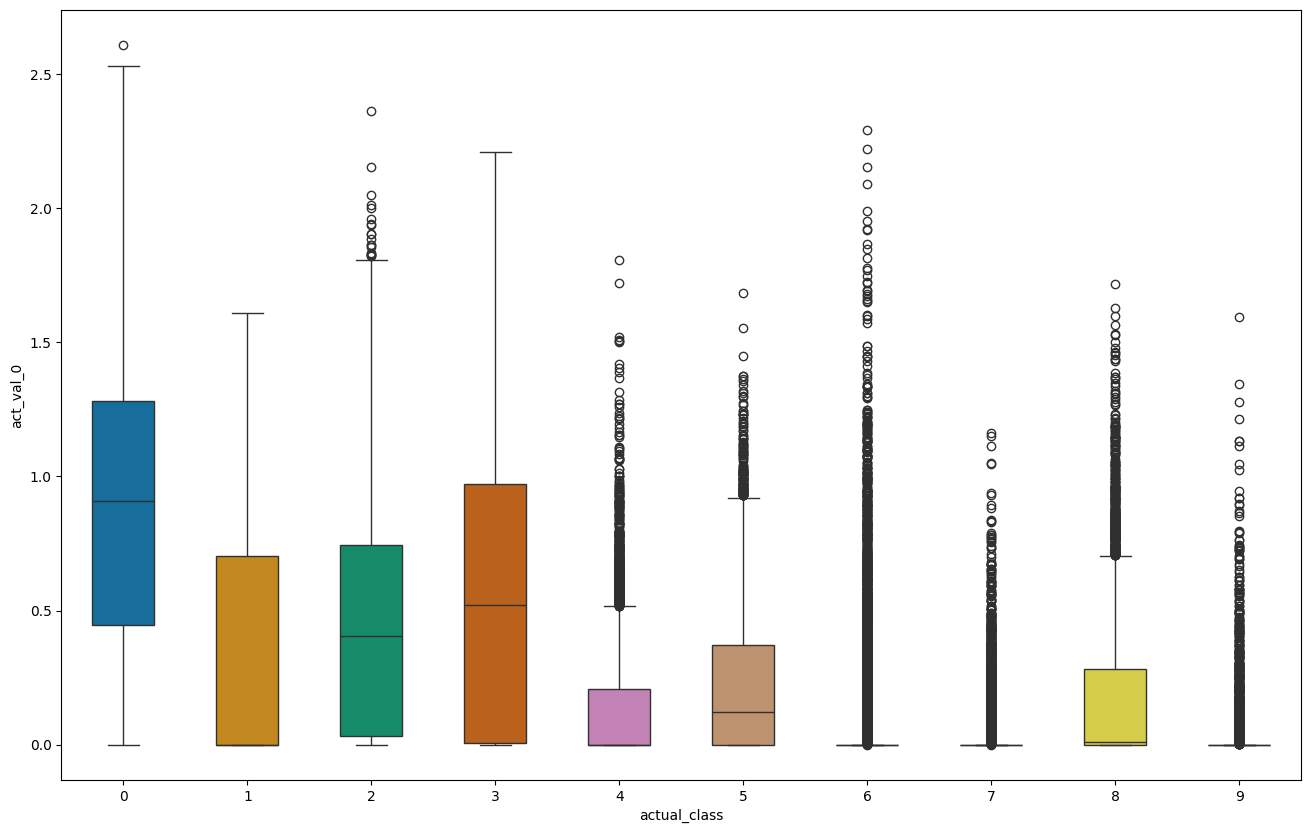

In [52]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
act_val = 'act_val_0'
plt.figure(figsize=(16,10))
bplot = sns.boxplot(y=act_val, x='actual_class',
                 data=activation_df[[act_val,'actual_class']],
                 width=0.5,
                 palette="colorblind")

## Displaying The Range Of Activation Values For Each Class Labels

In [53]:
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 2.61]"
1,1,"[0.0, 1.61]"
2,2,"[0.0, 2.36]"
3,3,"[0.0, 2.21]"
4,4,"[0.0, 1.81]"
5,5,"[0.0, 1.68]"
6,6,"[0.0, 2.29]"
7,7,"[0.0, 1.16]"
8,8,"[0.0, 1.72]"
9,9,"[0.0, 1.6]"


## Get Activation Values of the Pixel Values (784)

 ## Create a dataframe with the pixel values and class labels

In [54]:
#Get the dataframe of all the pixel values
pixel_data = {'actual_class':y_train}
for k in range(0,784):
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.0,1.0,9.0,2.0,1.0,3.0,1.0,4.0,3.0,5.0,3.0,6.0,1.0
pix_val_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pix_val_779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pix_val_782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
pixel_df.pix_val_77.value_counts()

,count
pix_val_77,
0.000000,59720
1.000000,25
0.996078,13
0.992157,9
0.050980,6
...,...
0.549020,1
0.925490,1
0.741176,1


In [56]:
pixel_df.pix_val_78.value_counts()

,count
pix_val_78,
0.000000,59862
1.000000,6
0.141176,4
0.960784,4
0.992157,4
...,...
0.709804,1
0.796078,1
0.607843,1


### Use a scatter plot to visualize the predicive power of the pixel values at two fixed locations in the image, i.e. how well the pixel values at two fixed locations in the image "predict" the class labels.

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `actual_class` values.

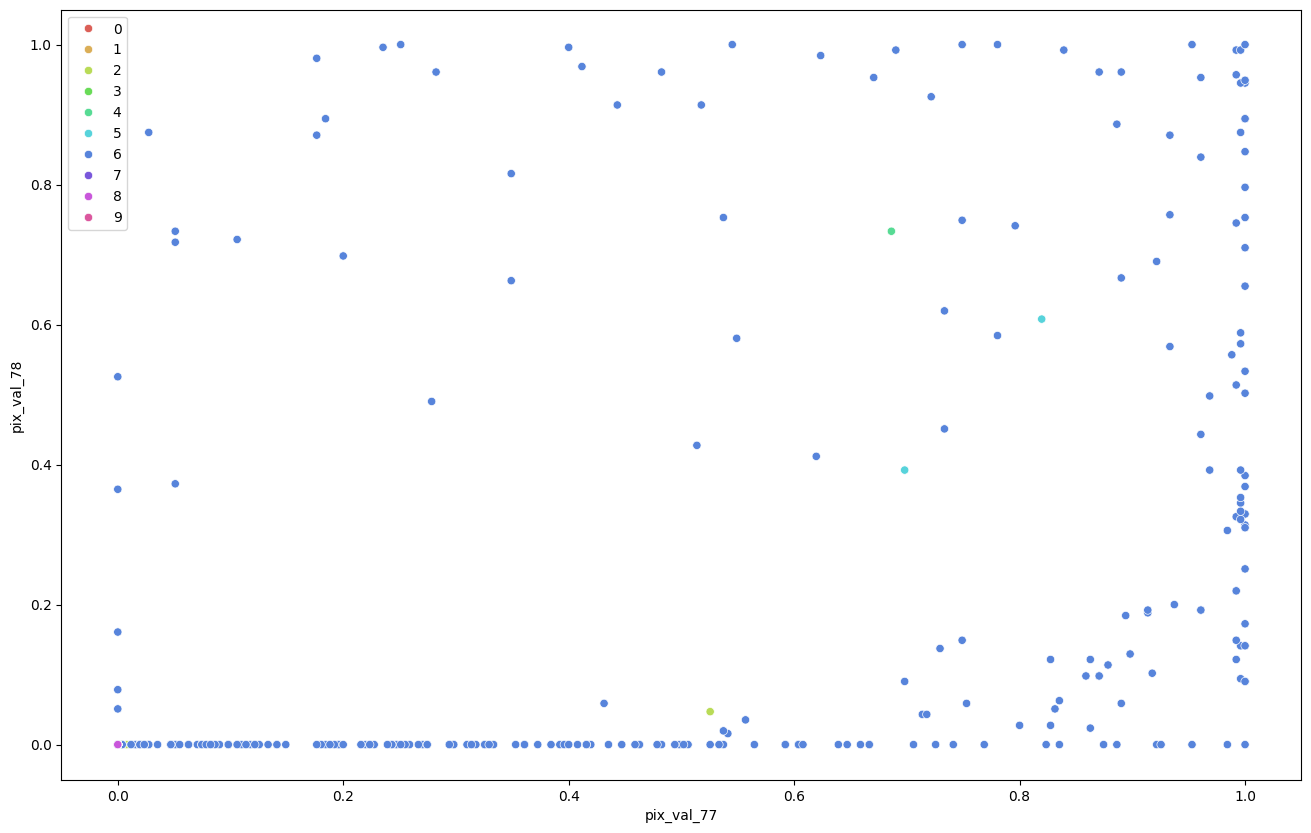

In [57]:
plt.figure(figsize=(16, 10))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="pix_val_77", y="pix_val_78", hue="actual_class",  palette=color, data = pixel_df, legend="full")
plt.legend(loc='upper left');

## PCA Feature Reduction / Model Optimization

<div class="alert alert-block alert-info">
    <b>sklearn.decomposition.PCA</b><br>
    https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    </div>

## Use PCA decomposition to reduce the number of features from 784 features to 2 features

In [58]:
# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [59]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['actual_class']]], axis = 1)

In [60]:
pixel_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,0.486,1.226,5
1,3.968,1.156,0
2,-0.203,-1.538,4
3,-3.134,2.381,1
4,-1.501,-2.865,9


In [61]:
pca.explained_variance_ratio_

array([0.097, 0.071], dtype=float32)

## Use a scatter plot to visualize the predictive power of the two principal component values.

Using seaborn this time...

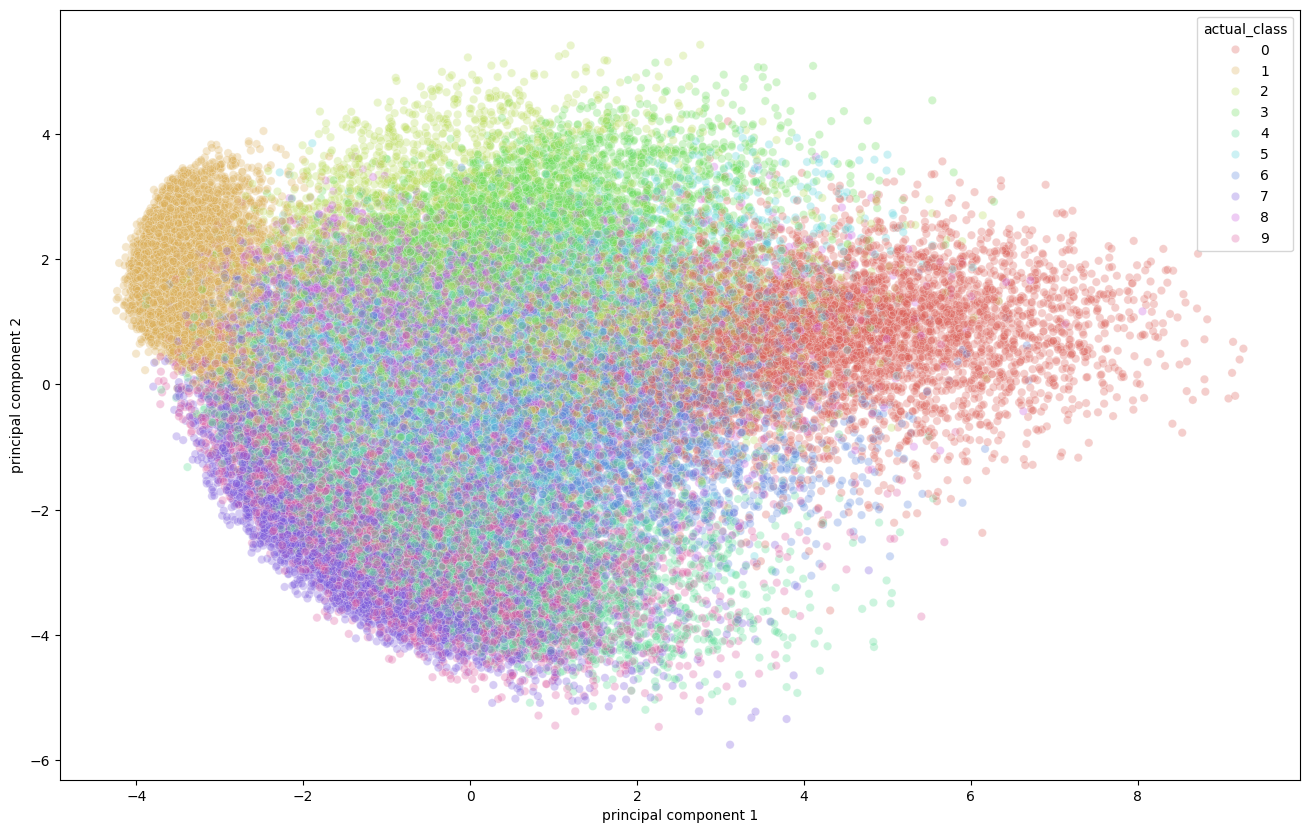

In [62]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
);

### Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 2

In [63]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head().round(3)

,principal component 1,principal component 2
0,0.954,3.616
1,5.036,-0.103
2,-1.154,-2.010
3,-1.823,0.371
4,-2.226,-1.065


In [64]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,principal component 1,principal component 2,actual_class
0,0.954,3.616,5
1,5.036,-0.103,0
2,-1.154,-2.010,4
3,-1.823,0.371,1
4,-2.226,-1.065,9


In [65]:
ev=pca.explained_variance_ratio_
ev

array([0.181, 0.123], dtype=float32)

In [66]:
print(f'The {len(ev)} principal components summed together {ev[0]:.3f} + {ev[1]:.3f} = {sum(ev):.3f} explained variance')

The 2 principal components summed together 0.181 + 0.123 = 0.304 explained variance


## Use a scatter plot to visualize the predictive power of *two* principal component values.

Using seaborn this time

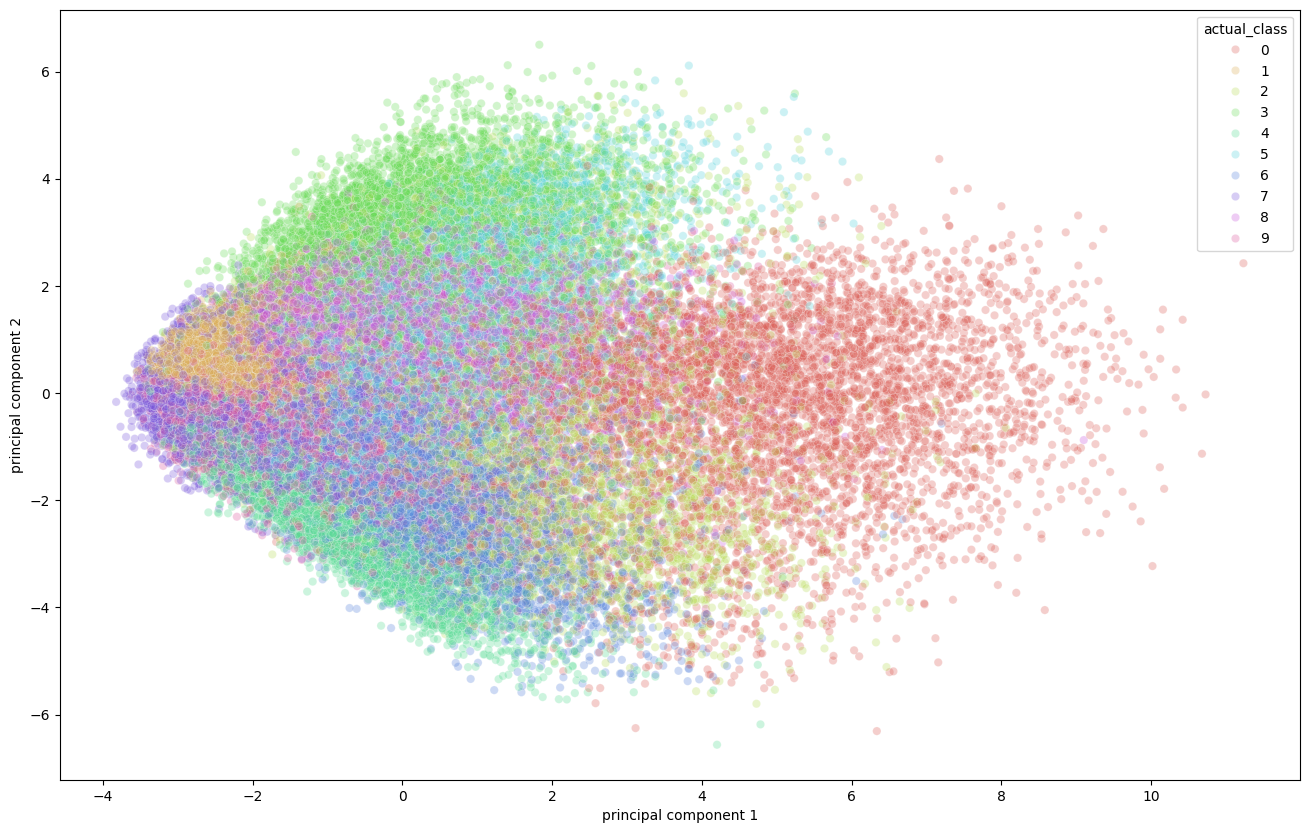

In [67]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="actual_class",
    palette=sns.color_palette("hls", 10),
    data=activation_pca_df,
    legend="full",
    alpha=0.3
);

### Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 3

In [68]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head(10).round(3).T

,0,1,2,3,4,5,6,7,8,9
pca-one,0.954,5.036,-1.154,-1.823,-2.226,0.942,-2.455,2.902,-2.956,-0.448
pca-two,3.616,-0.103,-2.010,0.371,-1.065,-2.192,1.355,3.503,0.828,-3.163
pca-three,-0.052,0.117,-0.587,1.472,-1.723,0.548,1.546,-1.635,1.469,0.583


In [69]:
ev=pca.explained_variance_ratio_
ev

array([0.181, 0.123, 0.104], dtype=float32)

In [70]:
print(f'The {len(ev)} principal components summed together {ev[0]:.3f} + {ev[1]:.3f} + {ev[2]:.3f} = {sum(ev):.3f} explained variance')

The 3 principal components summed together 0.181 + 0.123 + 0.104 = 0.409 explained variance


The 3 principal components summed together 0.169 + 0.105 + 0.099 = 0.373 explained variance

In [71]:
activation_pca_df = pd.concat([principalDf, activation_df[['actual_class']]], axis = 1)
activation_pca_df.head().round(3)

,pca-one,pca-two,pca-three,actual_class
0,0.954,3.616,-0.052,5
1,5.036,-0.103,0.117,0
2,-1.154,-2.010,-0.587,4
3,-1.823,0.371,1.472,1
4,-2.226,-1.065,-1.723,9


## Use t-Distributed Stochastic Neighbor Embedding (**t-SNE**)  to reduce the (activation) features from 128 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.

See http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

<div class="alert alert-block alert-info">
    <b>sklearn.manifold.TSNE</b><br>
    https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    </div>

In [72]:
activation_df.shape

(60000, 129)

In [73]:
N=60000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(60000, 129)

In [74]:
data_subset = activation_df_subset[features].values
data_subset.shape

(60000, 128)

In [75]:
%%time
tsne = TSNE(n_components=2
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=1
            ,perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.033s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 60000 samples in 42.116s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sample 13000 / 60000
[t-SNE] Computed conditional probabilities for sample 14000 / 6000

In [76]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

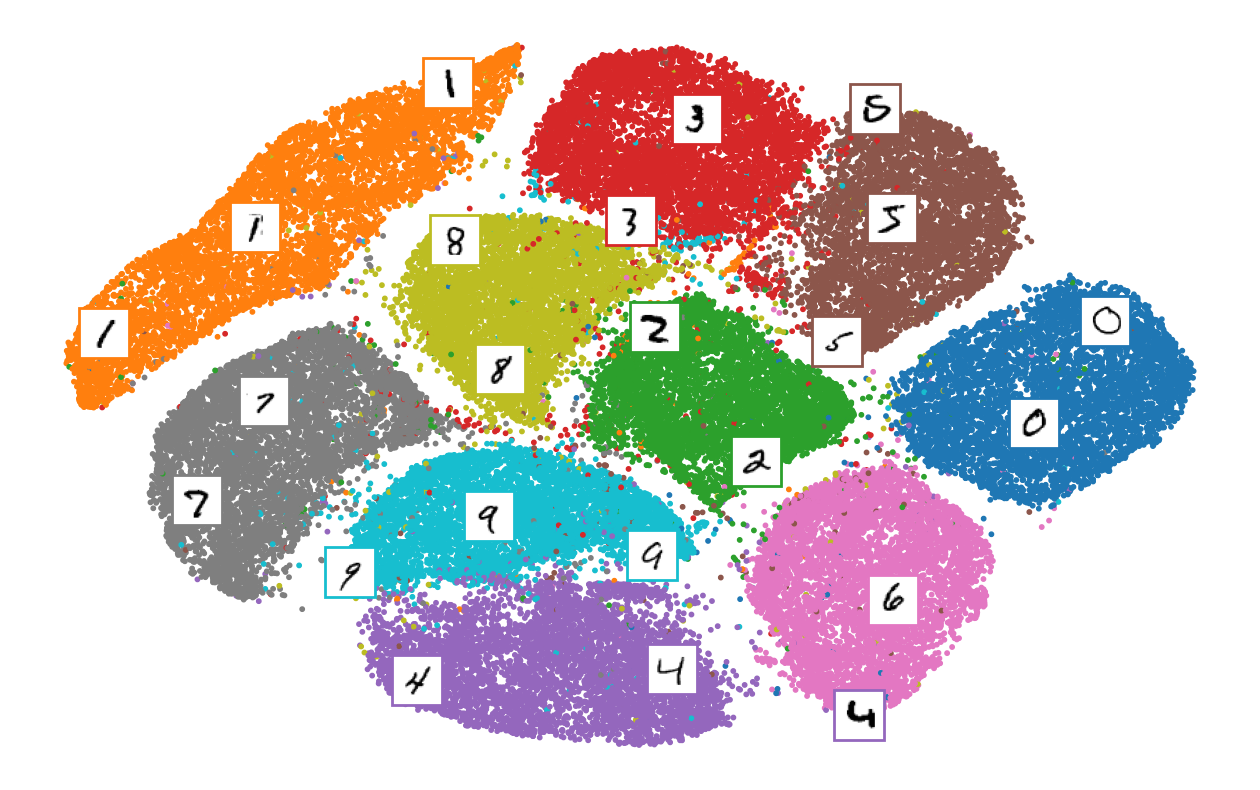

In [77]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_train, s=10, cmap=cmap)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## Reducing dimensionality of the data with Random Forests.

We create a Random Forest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features (using code from Hands On Machine Learning by A. Geron). Finally, we select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

<div class="alert alert-block alert-info">
    <b>sklearn.ensemble.RandomForestClassifier</b><br>
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    </div>

In [78]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(random_state=42)

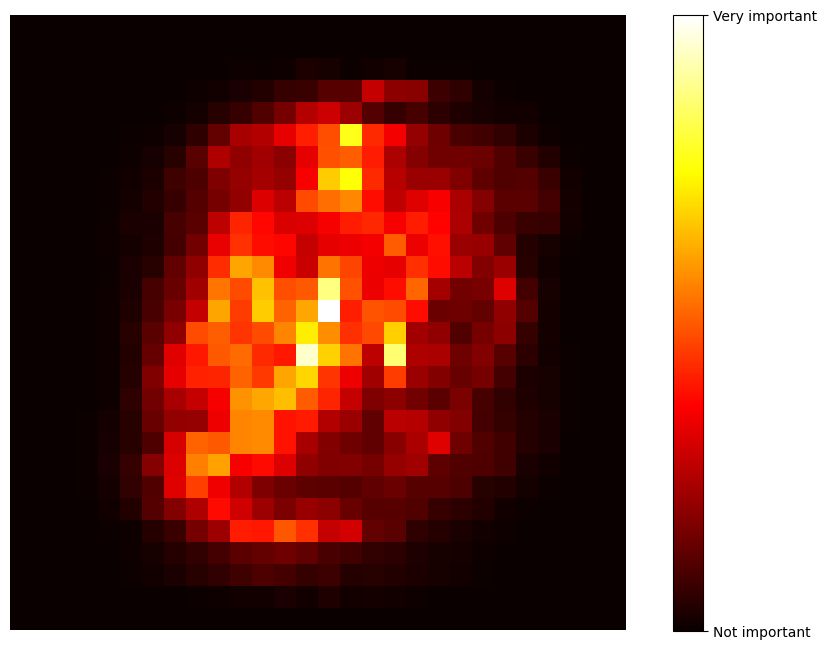

In [79]:
plt.figure(figsize = (12, 8))
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [80]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

## Create Training and Test Examples Leveraging 70 Pixels

In [81]:
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (10000, 70))

## Visualize the 70 pixels
We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

In [82]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size
    y = n%size
    return x,y

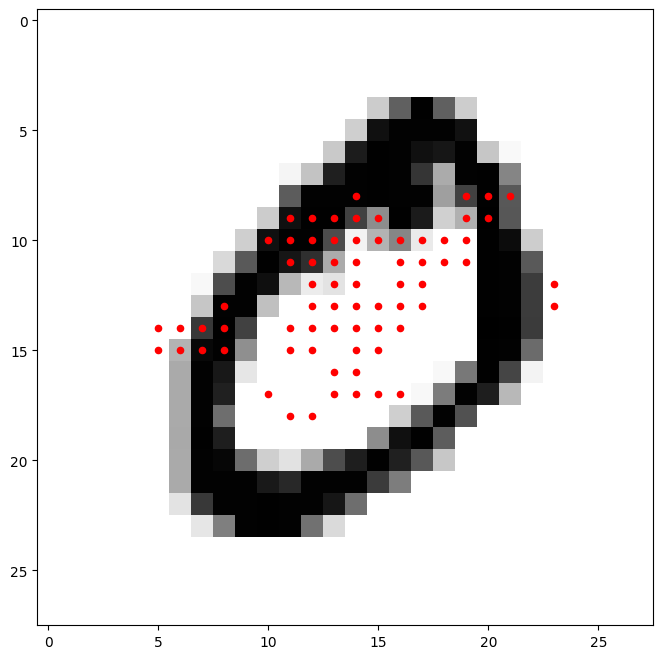

In [83]:
plt.figure(figsize = (12, 8))
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

In [84]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)


Last Run: 2025-04-06 22:22:57
